#### Dependencies

In [1]:
import numpy as np
import xarray as xr

# geo libs are optional
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
pwd   # should be top-level, i.e. ~/*/generative-downscaling/

'/home/jake/Projects/mila/6759/generative-downscaling/src/data'

In [6]:
temp_1 = xr.open_dataset("./data/raw/temp/1406/2m_temperature_1991_1.40625deg.nc")
temp_5 = xr.open_dataset("./data/raw/temp/5625/2m_temperature_1991_5.625deg.nc")

#### Basic XArray

In [11]:
temp_1

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256, time: 8760)
Coordinates:
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time     (time) datetime64[ns] 1991-01-01 ... 1991-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 05:53:15 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [12]:
temp_1.dims  # 8760/365 = 24!

Frozen({'lat': 128, 'lon': 256, 'time': 8760})

In [37]:
temp_5.dims

Frozen({'lat': 32, 'lon': 64, 'time': 8760})

In [14]:
temp_1.coords

Coordinates:
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time     (time) datetime64[ns] 1991-01-01 ... 1991-12-31T23:00:00

In [15]:
type(temp_1.t2m.data)

numpy.ndarray

#### Basic Filtering

In [7]:
daily = temp_1.isel(time=(temp_1.time.dt.hour == 0))
daily.dims

Frozen({'lat': 128, 'lon': 256, 'time': 365})

In [8]:
daily_5 = temp_5.isel(time=(temp_5.time.dt.hour == 0))
daily.dims

Frozen({'lat': 128, 'lon': 256, 'time': 365})

## Visual Exploration

### Location & Consistency

#### Where is the Data Located?

In [9]:
def plot_coords(pdf):  
    obs_by_geo = pdf.groupby(["lat","lon"]).size()
    obs_by_geo.name = "count"
    obs_by_geo = obs_by_geo.reset_index()

    gdf = GeoDataFrame(
        obs_by_geo,
        geometry=gpd.points_from_xy(obs_by_geo.lon - 180, obs_by_geo.lat)
    )

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=.05);

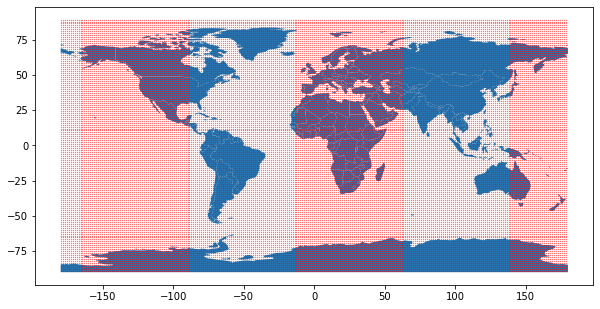

In [10]:
plot_coords(daily.to_dataframe())

In [82]:
EPSILON = .0001
NA_LAT = (0, 82+13+EPSILON)  # epsilon to avoid non-inclusive right
NA_LON = (-140+180, -50+180+EPSILON)  # epsilon to avoid non-inclusive right

daily_na = daily.sel(lat=slice(*NA_LAT), lon=slice(*NA_LON))

In [83]:
daily_na

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 64, time: 365)
Coordinates:
  * lat      (lat) float64 0.7031 2.109 3.516 4.922 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 40.78 42.19 43.59 45.0 ... 125.2 126.6 128.0 129.4
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
Data variables:
    t2m      (time, lat, lon) float32 298.5 298.5 299.0 ... 253.0 253.0 253.0
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 05:53:15 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

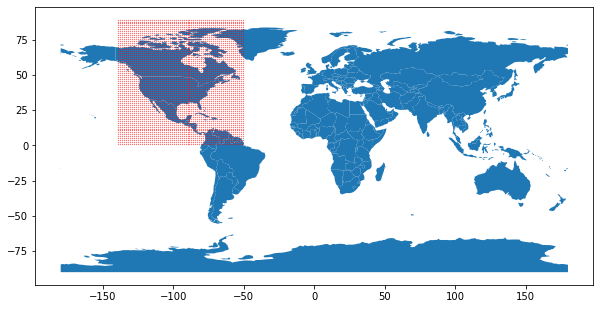

In [84]:
plot_coords(daily_na.to_dataframe())

#### Is the Data Consistent over Time?

In [12]:
daily_pdf = daily.to_dataframe()

In [13]:
obs_by_time = daily_pdf.groupby(["time"]).size()
obs_by_time.name = "count"
obs_by_time = obs_by_time.reset_index()

<AxesSubplot:xlabel='time'>

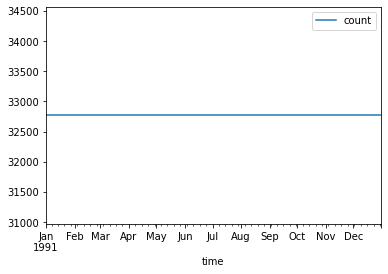

In [33]:
obs_by_time.plot(x="time", y="count")

In [34]:
daily_pdf = daily_5.to_dataframe()

In [35]:
obs_by_time = daily_pdf.groupby(["time"]).size()
obs_by_time.name = "count"
obs_by_time = obs_by_time.reset_index()

<AxesSubplot:xlabel='time'>

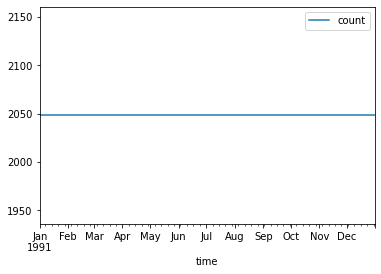

In [36]:
obs_by_time.plot(x="time", y="count");

### Temperature

In [65]:
t5_pdf = temp_5.to_dataframe()
# t5_pdf = t5_pdf[:100]

In [71]:
# coords = t5_pdf.reset_index()[['lat','lon']].drop_duplicates()
# coords[coords['lat'].between(40,50) & coords['lon'].between(70+180,80+180)]

coords_mtl_approx = (47.8125, 253.125)  # lat, lon

In [82]:
mtl_1991 = t5_pdf.loc[coords_mtl_approx[0]].loc[coords_mtl_approx[1]]

In [91]:
mtl_1991_hi_lo = mtl_1991\
    .groupby([mtl_1991.index.date])\
    .agg([np.min, np.max])\
    .rename(columns={'amin': 'low', 'amax': 'high'})

mtl_1991_hi_lo_c = mtl_1991_hi_lo - 273.15  # kelvin to celsius

<AxesSubplot:>

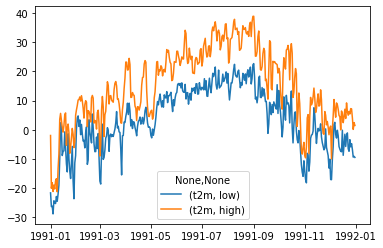

In [92]:
mtl_1991_hi_lo_c.plot()